In [29]:
import numpy as np
class Transfromations:
    trans_mat       = None
    trans_mat_inv   = None

    def __init__(self) -> None:
        pass

    def similarity(self, theta=0, tx=0, ty=0, s=1):
        theta = np.pi * theta / 180
        self.trans_mat = np.array([
            [s*np.cos(theta),   -s* np.sin(theta) ,        tx],
            [s*np.sin(theta),   s* np.cos(theta),          ty],
            [0,                 0,                          1]
        ])
        self.inv_matrix()
        return

    def isometric(self, theta=0, tx=0, ty=0, ep=1):
        theta = np.pi * theta / 180
        self.trans_mat = np.array([
            [ep*np.cos(theta), -1 * np.sin(theta) , tx],
            [ep*np.sin(theta), np.cos(theta), ty],
            [0, 0, 1]
        ])
        self.inv_matrix()
        return
    
    def affinity(self, theta=0, phi=0, lambda1=1, lambda2=1, tx=0, ty=0):
        D = np.array([
            [lambda1, 0],
            [0, lambda2]
        ])
        A = self.R(theta) @ self.R(-phi) @ D @ self.R(phi)
        self.trans_mat = np.array([
            [A[0][0], A[0][1], tx],
            [A[1][0], A[1][1], ty],
            [0,       0,        1]
        ])
        self.inv_matrix()
        return
        
    def R(self,angle):
        angle = np.pi * angle / 180
        R = np.array([
            [np.cos(angle), -1*np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])
        return R
    
    def projectivity(self, s=1, theta=0, tx=0, ty=0, v1=0, v2=0, v=0, K=[1,1,0,1]):
        theta = np.pi * theta / 180
        Hs = np.array([
            [s*np.cos(theta),   -s * np.sin(theta) ,        tx],
            [s*np.sin(theta),   s * np.cos(theta),          ty],
            [0,                 0,                          1]
        ])
        Ha = np.array([
            [K[0],K[1], 0],
            [K[2],K[3], 0],
            [0,   0,    1]
        ])
        Hp = np.array([
            [1 ,0,  0],
            [0 ,1,  0],
            [v1,v2, v]
        ])
        self.trans_mat = Hs @ Ha @ Hp
        self.inv_matrix()
        return
    
    def inv_matrix(self):
        self.trans_mat_inv = np.linalg.inv(self.trans_mat)
        return
    
    def transform_direct(self, point=None, points=None):
        if point is not None: 
            point = self.trans_mat @ point
            point = [point[0]/point[2], point[1]/point[2], 1]
            return point
        return np.array([self.trans_mat @ point_ for point_ in points])
    
    def transform_reverse(self, point=None, points=None):
        if point is not None: return self.trans_mat_inv @ point
        return np.array([point_@self.trans_mat_inv for point_ in points])


In [30]:
class Utitly:
    def interpolation(self, ref_point, points):
        x = ref_point[0]
        y = ref_point[1]
        x0 = int(x)
        y0 = int(y)
        x1 = x0 + 1
        y1 = y0 + 1

        dx = x - x0
        dy = y - y0

        interpolated_value = (1 - dx) * (1 - dy) * points[x0, y0] + \
                            dx * (1 - dy) * points[x1, y0] + \
                            (1 - dx) * dy * points[x0, y1] + \
                            dx * dy * points[x1, y1]

        return int(interpolated_value)
    def rectangle(self, x=0, y=0, width=1, length=1, step=.1, cetner=False):
        if cetner:
            x = -1*int(width/2)
            y = -1*int(length/2)
        step_inv = int(1 / step)
        vertices = [(x, y), (x + width, y), (x + width, y + length), (x, y + length)]
        # Generate the points along the edges of the square
        points = []
        for i in range(len(vertices)):
            x1, y1 = vertices[i]    
            x2, y2 = vertices[(i + 1) % len(vertices)]
            if x1 == x2:  # Vertical edge        
                points.extend([[x1, y * step, 1] for y in range(min(y1, y2)*step_inv, max(y1, y2)*step_inv + 1, 1)])
            else:  # Horizontal edge        
                points.extend([[x * step, y1, 1] for x in range(min(x1, x2)*step_inv, max(x1, x2)*step_inv + 1, 1)])
        # Separate the x and y coordinates
        x_coords, y_coords, _ = zip(*points)
        return points, x_coords, y_coords


In [31]:
import cv2
import matplotlib.pyplot as plt
class ImageTransformation(Transfromations):
    src = None
    interpolation = None
    def __init__(self, src) -> None:
        self.src = src
        self.interpolation = Utitly().interpolation

    def transform(self, xsize_coe=1, ysize_coe=1):
        im = cv2.imread(self.src, cv2.IMREAD_GRAYSCALE)
        xsize, ysize = xsize_coe*im.shape[0], ysize_coe*im.shape[1]
        offset=2
        im=cv2.copyMakeBorder(im,offset,offset,offset,offset,cv2.BORDER_CONSTANT,value=0)
        new_img = []
        for i in range(xsize):
            for j in range(ysize):
                ref_point = self.transform_reverse(point=[i,j,1])
                if -1<ref_point[0]<im.shape[0]-1 and -1<ref_point[1]<im.shape[1]-1:
                    grayInterpolation=self.interpolation(ref_point,im)
                    new_img.append([i,j, grayInterpolation])
                else: new_img.append([i,j,0])
        new_img = np.asarray(new_img)
        X, Y, C = zip(*new_img)
        result_matrix = np.zeros((xsize, ysize))
        result_matrix[X, Y] = C
        plt.imshow(result_matrix, cmap='gray', vmin=0, vmax=255)
        plt.show()
        return result_matrix


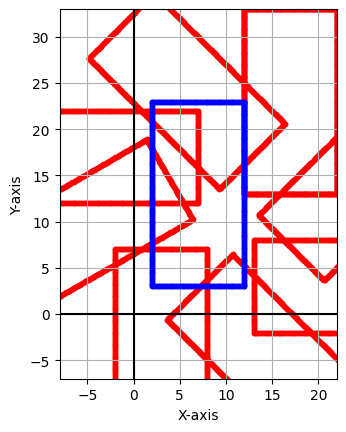

In [32]:
trans = Transfromations()

fig, ax = plt.subplots()

angles = [0, 45, 90, 120, 180, 225, 270, 315, 360]

points, x_coords, y_coords = Utitly().rectangle(x=2, y=3, width=10, length=20, cetner=False)
ax.scatter(x_coords, y_coords, marker='.', color='b', zorder=10)

for angle in angles:
    trans.similarity(angle, tx=10, ty=10)
    points2= trans.transform_direct(point=None, points=points).tolist()
    x_coords2 , y_coords2, _ = zip(*points2)
    ax.scatter(x_coords2, y_coords2, marker='.', color='r')

# Set the axis limits
xlim = 10
ylim = 10
ax.set_xlim(min(x_coords) - xlim, max(x_coords) + xlim)
ax.set_ylim(min(y_coords) - ylim, max(y_coords) + ylim)
# Set the axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
# Display the grid
ax.grid(True)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_aspect('equal', adjustable='box')
plt.show()


In [33]:
tr = Transfromations()
tr.similarity(theta=0, tx=512, ty=512, s=1)
print(tr.trans_mat_inv)

[[   1.    0. -512.]
 [   0.    1. -512.]
 [   0.    0.    1.]]


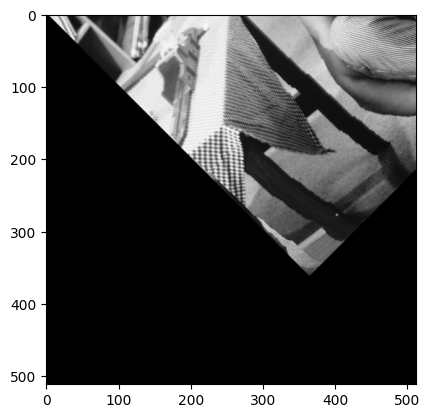

array([[  0.,   0.,  37., ...,  93.,  47.,  88.],
       [  0.,   0.,   0., ...,  71.,  42., 101.],
       [  0.,   0.,   0., ...,  63.,  35., 110.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [38]:
img_trans = ImageTransformation('../src/barbara_gray.bmp')
img_trans.similarity(45, s=1, tx=0, ty=0)
img_trans.transform(xsize_coe=1, ysize_coe=1)

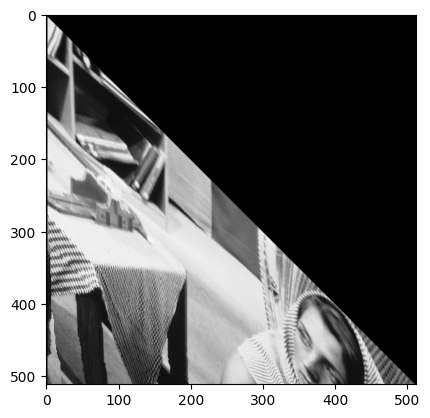

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0., 54., ...,  0.,  0.,  0.],
       [ 0.,  0., 60., ...,  0.,  0.,  0.],
       [ 0.,  0., 66., ..., 85.,  0.,  0.]])

In [35]:
img_trans = ImageTransformation('../src/barbara_gray.bmp')
img_trans.projectivity(s=1, theta=0, tx=0, ty=0, v1=.1, v2=.1, v=.001, K=[1,1,0,1])
img_trans.transform()